In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

import keras

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras
print (keras.__version__)

%matplotlib inline
sns.set(style="white")

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8] # width, height

Using TensorFlow backend.


2.1.4


In [2]:
# Configuration 

# Data sources
include_bitcoin = 1
include_ethereum = 1
include_litecoin = 1
include_ripple = 1
include_goog_trends = 1
include_stocktwits = 0

# Data duration (training + test)
start_date_ = '2015-08-07'
end_date_ = '2018-04-18'

start_date = start_date_.replace("-", "")
end_date = end_date_.replace("-", "")

split_date = '2018-01-20'  # >10% of full dataset

# Target : Predict bitcoin (OR ethereum) daily returns OR volatility 
# target = 'btc_daily_ret'
target = 'btc_volatility'

# target = 'eth_daily_ret'
# target = 'eth_volatility'

# Explore further
# target = 'ltc_daily_ret'
# target = 'xrp_daily_ret'

coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}


In [3]:
# Load dataset
dataset_df = pd.read_pickle("data/full_dataset.pkl")

In [4]:
dataset_df.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


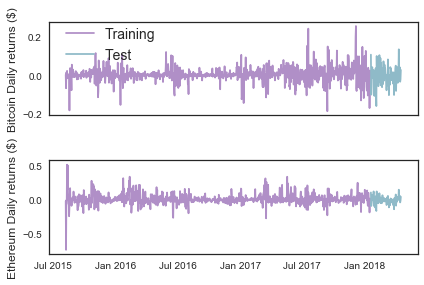

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_daily_ret'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_daily_ret'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_daily_ret'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_daily_ret'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily returns ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily returns ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

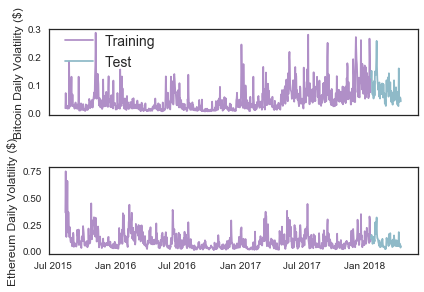

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_volatility'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_volatility'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_volatility'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_volatility'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily Volatility ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily Volatility ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

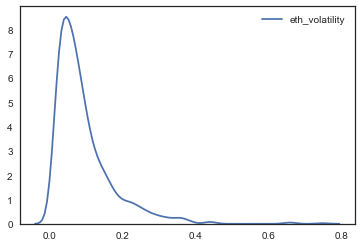

In [7]:
sns.kdeplot(dataset_df['eth_volatility'])

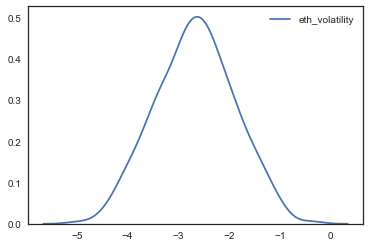

In [8]:
sns.kdeplot(np.log(dataset_df['eth_volatility']))

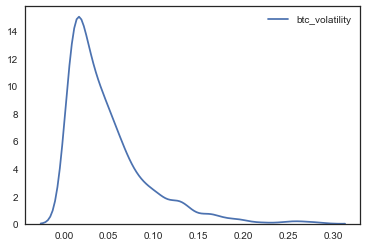

In [9]:
sns.kdeplot(dataset_df['btc_volatility'])

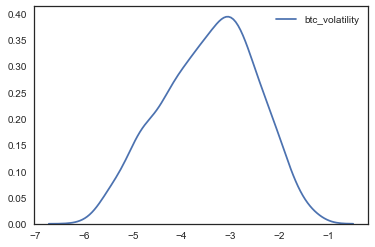

In [10]:
sns.kdeplot(np.log(dataset_df['btc_volatility']))

In [11]:
dataset_df['eth_volatility'] = np.log(dataset_df['eth_volatility'])
dataset_df['btc_volatility'] = np.log(dataset_df['btc_volatility'])

# Benchmarks

Benchmark -I: Price-Persistent model, assumes the close price is same as the previous day. Implies that the estimated daily returns and volatility are both zero

Benchmark - II: Market-Persistent model, assumes the daily returns is same as the previous day. Implies the estimated daily returns and volatility are same as the previous day.

In [12]:
## Price-PERSISTENT MODEL: Benchmark-I

print ("Predicting:", target)

# Evaluate on test dataset
# no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
actual_target = dataset_df[dataset_df['Date']>= split_date][target].values
# pred_target = 0

bm1_mae = np.mean(np.absolute((actual_target)))
bm1_mse = np.mean(np.square((actual_target)))

print("Benchmark-I: MAE", bm1_mae)
print("Benchmark-I: MSE", bm1_mse)

Predicting: btc_volatility
Benchmark-I: MAE 2.634264923378126
Benchmark-I: MSE 7.188424481804465


In [13]:
## Market-PERSISTENT MODEL: Benchmark-II

# Evaluate on test dataset
# same market behavior as previous day
pred_target = dataset_df[dataset_df['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)][target][:-1].values

bm2_mae = np.mean(np.absolute((actual_target-pred_target)))
bm2_mse = np.mean(np.square((actual_target-pred_target)))

print("Benchmark-II: MAE", bm2_mae)
print("Benchmark-II: MSE", bm2_mse)

Benchmark-II: MAE 0.4218536832328074
Benchmark-II: MSE 0.2821991334719368


In [14]:
## LSTM Begins
symbols_ = [symbol+"_" for symbol in list(coin_symbol.values())]

model_data = dataset_df
model_data.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


In [15]:
# LSTM Parameters
window_len = 2 # 2 # 7 # 14 # 30

training_set, test_set = model_data[model_data['Date']<split_date], \
                         model_data[model_data['Date']>=datetime.datetime.strptime(split_date, '%Y-%m-%d')-datetime.timedelta(days=window_len)]

# we don't need the date columns anymore
########### DONT'WE ?? - If we are to cross-validation, we need the dates!! or we just use the index?
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [16]:
no_of_features = training_set.shape[1]

# Columns to be normalized - Instead of traditional normalization aschemes (like MinMax on training_set), 
# normalize the columns w.r.t to the first element of the window s.t the normalized first element would be 0 
# Reference: 
norm_cols = [[symbol+metric for symbol in symbols_ for metric in ['Close','Volume']]          
             +[coin_symbol[coin]+"_trends" for coin in coins]]

norm_cols

[['btc_Close',
  'btc_Volume',
  'eth_Close',
  'eth_Volume',
  'ltc_Close',
  'ltc_Volume',
  'xrp_Close',
  'xrp_Volume',
  'btc_trends',
  'eth_trends',
  'ltc_trends',
  'xrp_trends']]

In [17]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = training_set[target][window_len:].values

In [18]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = test_set[target][window_len:].values

print(len(training_set))
print(len(test_set))

897
91


In [19]:
# ???  easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

type(LSTM_test_inputs)
print(LSTM_test_inputs.shape, LSTM_training_inputs.shape)

(89, 2, 32) (895, 2, 32)


In [20]:
# Function to create model, required for KerasRegressor
def create_model(dropout, neurons, activ_func, optimizer):
    # use default values
    loss= 'mse'
    output_size = 1 # TODO: Can we change this to 2 or even 4 (to predict all 4 at a time - {eth, btc}_{volatility, daily_ret})
    
    print ("Start model: ", dropout, neurons)
    
    model = Sequential()

    # Add 3 layers of LSTM, followed by a dense layer
    model.add(LSTM(neurons[0], return_sequences=True, input_shape=(window_len, no_of_features)))
    model.add(Dropout(dropout))
    # from keras.layers.normalization import BatchNormalization
    # model.add(BatchNormalization())
    
    model.add(LSTM(neurons[1], return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(neurons[2]))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    print ("End compilation of model: ", dropout, neurons)
        
    return model

In [21]:
# Set random seed for reproducibility
np.random.seed(42)

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=2)
# model.fit(predictors, target, validation_split=0.3, epochs=100, callbacks=[early_stopping_monitor])

# create model
model = KerasRegressor(build_fn=create_model, batch_size=4, epochs=15) #, callbacks=[early_stopping_monitor]) 

##############################################################
# grid search: dropout, neurons, optimizer, activation
dropout = [0.4, 0.5, 0.6] # [0.25, 0.5, 0.75]
neurons = [[10, 8, 4], [20, 16, 8], [40, 32, 16]] # [80, 64, 32], [160, 128, 64]
activations = ['linear', 'tanh'] # , 'linear'] # , 'sigmoid']
optimizer = ['adam', 'rmsprop'] #, 'adam']
param_space = dict(dropout=dropout, neurons=neurons, activ_func=activations, optimizer=optimizer)
##############################################################

tseries_cv = TimeSeriesSplit(n_splits=5).split(LSTM_training_inputs)

grid = GridSearchCV(estimator=model, param_grid=param_space, n_jobs=1, cv=tseries_cv, verbose=5)

print ("Train input shape: ", LSTM_training_inputs.shape)
print ("Train output shape: ", LSTM_training_outputs.shape)

grid_result = grid.fit(LSTM_training_inputs, LSTM_training_outputs)

Train input shape:  (895, 2, 32)
Train output shape:  (895,)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] activ_func=linear, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 3s 19ms/step - loss: 12.7083
Epoch 2/15
150/150 [==============================] - 0s 1ms/step - loss: 11.3515
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 9.1115
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 6.1768
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 3.7803
Epoch 6/15
150/150 [==============================] - 0s 1ms/step - loss: 2.9385
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 2.5986
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 2.2771
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 2.4947
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
299/299 [==============================] - 4s 13ms/step - loss: 14.7369
Epoch 2/15
299/299 [==============================] - 0s 1ms/step - loss: 11.8758
Epoch 3/15
299/299 [==============================] - 0s 2ms/step - loss: 5.7863
Epoch 4/15
299/299 [==============================] - 0s 2ms/step - loss: 3.2314
Epoch 5/15
299/299 [==============================] - 0s 2ms/step - loss: 2.7978
Epoch 6/15
299/299 [==============================] - 0s 1ms/step - loss: 3.0226
Epoch 7/15
299/299 [==============================] - 0s 2ms/step - loss: 2.6006
Epoch 8/15
299/299 [==============================] - 0s 1ms/step - loss: 2.5842
Epoch 9/15
299/299 [==============================] - 0s 1ms/step - loss: 2.4913
Epoch 10/15
299/299 [==============================] - 1s 2ms/step - loss: 2.6473
Epoch 11/15
299/299 [==============================] - 0s 2ms/step - loss: 2.4475
Epoch 12/15
299/299 [==============================] - 1s 2ms/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.0s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
448/448 [==============================] - 4s 9ms/step - loss: 15.3574
Epoch 2/15
448/448 [==============================] - 1s 2ms/step - loss: 9.0781
Epoch 3/15
448/448 [==============================] - 1s 2ms/step - loss: 3.0170
Epoch 4/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7154
Epoch 5/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7841
Epoch 6/15
448/448 [==============================] - 1s 2ms/step - loss: 2.6449
Epoch 7/15
448/448 [==============================] - 1s 2ms/step - loss: 2.8232
Epoch 8/15
448/448 [==============================] - 1s 2ms/step - loss: 2.8854
Epoch 9/15
448/448 [==============================] - 1s 2ms/step - loss: 2.5431
Epoch 10/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7032
Epoch 11/15
448/448 [==============================] - 1s 2ms/step - loss: 2.5736
Epoch 12/15
448/448 [==============================] - 1s 2ms/st

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.8s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
597/597 [==============================] - 4s 7ms/step - loss: 12.6167
Epoch 2/15
597/597 [==============================] - 1s 2ms/step - loss: 3.8223
Epoch 3/15
597/597 [==============================] - 1s 2ms/step - loss: 2.8593
Epoch 4/15
597/597 [==============================] - 1s 2ms/step - loss: 3.2265
Epoch 5/15
597/597 [==============================] - 1s 2ms/step - loss: 3.0674
Epoch 6/15
597/597 [==============================] - 1s 2ms/step - loss: 2.6422
Epoch 7/15
597/597 [==============================] - 1s 2ms/step - loss: 2.3959
Epoch 8/15
597/597 [==============================] - 1s 2ms/step - loss: 2.5750
Epoch 9/15
597/597 [==============================] - 1s 1ms/step - loss: 2.3072
Epoch 10/15
597/597 [==============================] - 1s 1ms/step - loss: 2.3955
Epoch 11/15
597/597 [==============================] - 1s 2ms/step - loss: 2.2398
Epoch 12/15
597/597 [==============================] - 1s 1ms/st

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
746/746 [==============================] - 4s 5ms/step - loss: 10.7920
Epoch 2/15
746/746 [==============================] - 1s 1ms/step - loss: 3.2136
Epoch 3/15
746/746 [==============================] - 1s 2ms/step - loss: 2.8554
Epoch 4/15
746/746 [==============================] - 1s 2ms/step - loss: 2.4575
Epoch 5/15
746/746 [==============================] - 1s 1ms/step - loss: 2.6444
Epoch 6/15
746/746 [==============================] - 1s 1ms/step - loss: 2.4016
Epoch 7/15
746/746 [==============================] - 1s 1ms/step - loss: 2.3867
Epoch 8/15
746/746 [==============================] - 1s 1ms/step - loss: 2.2683
Epoch 9/15
746/746 [==============================] - 1s 1ms/step - loss: 2.2542
Epoch 10/15
746/746 [==============================] - 1s 1ms/step - loss: 1.9709
Epoch 11/15
746/746 [==============================] - 1s 1ms/step - loss: 2.0996
Epoch 12/15
746/746 [==============================] - 1s 1ms/st

746/746 [==============================] - 6s 8ms/step - loss: 11.9132
Epoch 2/15
746/746 [==============================] - 1s 2ms/step - loss: 4.8100
Epoch 3/15
746/746 [==============================] - 1s 2ms/step - loss: 2.8573A: 0s - loss: 2.88
Epoch 4/15
746/746 [==============================] - 1s 2ms/step - loss: 2.2158
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 2.3210
Epoch 6/15
746/746 [==============================] - 1s 2ms/step - loss: 2.0938
Epoch 7/15
746/746 [==============================] - 1s 1ms/step - loss: 2.0778
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9304A:
Epoch 9/15
746/746 [==============================] - 1s 1ms/step - loss: 1.8369
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6678
Epoch 11/15
746/746 [==============================] - 1s 1ms/step - loss: 1.7293
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 1.4986
Epoch 13/15
746

746/746 [==============================] - 1s 2ms/step - loss: 1.8681
Epoch 4/15
746/746 [==============================] - 1s 1ms/step - loss: 1.6771
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6601
Epoch 6/15
746/746 [==============================] - 1s 1ms/step - loss: 1.7271A: 0s - 
Epoch 7/15
746/746 [==============================] - 1s 1ms/step - loss: 1.6607
Epoch 8/15
746/746 [==============================] - 1s 1ms/step - loss: 1.4507
Epoch 9/15
746/746 [==============================] - 1s 1ms/step - loss: 1.4598
Epoch 10/15
746/746 [==============================] - 1s 1ms/step - loss: 1.3984
Epoch 11/15
746/746 [==============================] - 1s 1ms/step - loss: 1.2828
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 1.2621
Epoch 13/15
746/746 [==============================] - 1s 1ms/step - loss: 1.2836
Epoch 14/15
746/746 [==============================] - 1s 1ms/step - loss: 1.2209
Epoch 15/15
746/746 [=====

746/746 [==============================] - 1s 2ms/step - loss: 1.7618
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6780
Epoch 6/15
746/746 [==============================] - 1s 2ms/step - loss: 1.5168
Epoch 7/15
746/746 [==============================] - 1s 2ms/step - loss: 1.4916
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3475
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3301
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 1.1721
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 1.2657
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 1.2791
Epoch 13/15
746/746 [==============================] - 2s 2ms/step - loss: 1.2312
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 1.0943
Epoch 15/15
746/746 [==============================] - 0s 476us/step
[CV]  activ_func=linear, dropout=0.4, neurons=

746/746 [==============================] - 1s 2ms/step - loss: 1.1322
Epoch 7/15
746/746 [==============================] - 1s 2ms/step - loss: 1.0520
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 1.0229
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9590
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9909
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9443
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9722
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.0063
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9562
Epoch 15/15
746/746 [==============================] - 0s 488us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=adam, score=-0.3975531223836361, total=  31.9s
[CV] activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop 
Start model: 

746/746 [==============================] - 1s 2ms/step - loss: 1.0077
Epoch 9/15
746/746 [==============================] - 2s 2ms/step - loss: 1.0385
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9331
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 0.8358
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 0.8915
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 0.8983
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 0.9729
Epoch 15/15
746/746 [==============================] - 0s 564us/step
[CV]  activ_func=linear, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.3864166678598263, total=  40.8s
[CV] activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 11s 72ms/step - loss: 12.9561
Epoch 2/15
150/150 [==

746/746 [==============================] - 1s 2ms/step - loss: 2.2060
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 2.5344
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 2.0007
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9582
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9774
Epoch 15/15
746/746 [==============================] - 0s 599us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=adam, score=-0.303386985655599, total=  39.9s
[CV] activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 11s 74ms/step - loss: 12.7388
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 11.8544
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 10.4977
Epoch 4/15
150/150 [====

746/746 [==============================] - 1s 2ms/step - loss: 1.7324
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6993
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 1.5322
Epoch 15/15
746/746 [==============================] - 0s 581us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop, score=-0.3447647607266503, total=  40.0s
[CV] activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
150/150 [==============================] - 12s 77ms/step - loss: 12.6892
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 10.5870
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 4.9522
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 2.2248
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 2.0975
Epoch 6/15
150/150 [===

746/746 [==============================] - 1s 2ms/step - loss: 1.6220
Epoch 15/15
746/746 [==============================] - 0s 652us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=adam, score=-0.3047476941407127, total=  45.8s
[CV] activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
150/150 [==============================] - 15s 101ms/step - loss: 12.5479
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 10.2980
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 6.7354
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 4.1593
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 2.4719
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 2.7074
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 2.0140
Epoch 8/15
150/150 [===

746/746 [==============================] - 0s 657us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop, score=-0.2943960742262386, total=  46.9s
[CV] activ_func=linear, dropout=0.5, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
150/150 [==============================] - 14s 95ms/step - loss: 11.7368
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 4.7390
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 1.7142
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 1.3310
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 1.5445
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 1.4916
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 1.2454
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 1.2463
Epoch 9/15
150/150 [===

End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
150/150 [==============================] - 17s 115ms/step - loss: 10.7615
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 3.1314
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 1.5746
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 1.3623
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 1.5489
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 1.5246
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 1.8195
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 1.5093
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 1.4901
Epoch 10/15
150/150 [==============================] - 0s 2ms/step - loss: 1.4156
Epoch 11/15
150/150 [==============================] - 0s 2ms/step - loss: 1.1465
Epoch 12/15
150/150 [==============================] - 0s 2

150/150 [==============================] - 0s 2ms/step - loss: 12.0087
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 10.6953
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 8.8999
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 6.6213
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 5.0613
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 4.5741
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 4.4935
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 3.6809
Epoch 10/15
150/150 [==============================] - 0s 2ms/step - loss: 4.0632
Epoch 11/15
150/150 [==============================] - 0s 2ms/step - loss: 4.3496
Epoch 12/15
150/150 [==============================] - 0s 2ms/step - loss: 4.0759
Epoch 13/15
150/150 [==============================] - 0s 2ms/step - loss: 4.1613
Epoch 14/15
150/150 [============

150/150 [==============================] - 0s 2ms/step - loss: 10.7529
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 9.6831
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 9.0012
Epoch 7/15
150/150 [==============================] - 0s 3ms/step - loss: 7.4016A: 0s - loss: 7.71
Epoch 8/15
150/150 [==============================] - 0s 3ms/step - loss: 6.3426
Epoch 9/15
150/150 [==============================] - 1s 3ms/step - loss: 5.3354
Epoch 10/15
150/150 [==============================] - 0s 3ms/step - loss: 4.9694
Epoch 11/15
150/150 [==============================] - 0s 3ms/step - loss: 4.2867
Epoch 12/15
150/150 [==============================] - 0s 2ms/step - loss: 4.6114
Epoch 13/15
150/150 [==============================] - 0s 2ms/step - loss: 3.3104
Epoch 14/15
150/150 [==============================] - 0s 2ms/step - loss: 3.1500
Epoch 15/15
150/150 [==============================] - 0s 789us/step
[CV]  activ_func=linear, dr

150/150 [==============================] - 0s 2ms/step - loss: 2.9197
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 3.1143
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 2.6172
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 2.6804
Epoch 10/15
150/150 [==============================] - 0s 2ms/step - loss: 2.8889
Epoch 11/15
150/150 [==============================] - 0s 2ms/step - loss: 2.4907
Epoch 12/15
150/150 [==============================] - 0s 2ms/step - loss: 2.8222
Epoch 13/15
150/150 [==============================] - 0s 2ms/step - loss: 2.6817
Epoch 14/15
150/150 [==============================] - 0s 2ms/step - loss: 2.9373
Epoch 15/15
150/150 [==============================] - 0s 815us/step
[CV]  activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=adam, score=-1.2614999289480633, total=  39.9s
[CV] activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.6 

150/150 [==============================] - 0s 2ms/step - loss: 3.0729
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 2.7403
Epoch 10/15
150/150 [==============================] - 0s 2ms/step - loss: 3.0848
Epoch 11/15
150/150 [==============================] - 0s 2ms/step - loss: 2.5473
Epoch 12/15
150/150 [==============================] - 0s 2ms/step - loss: 2.3951
Epoch 13/15
150/150 [==============================] - 0s 2ms/step - loss: 2.4058
Epoch 14/15
150/150 [==============================] - 0s 2ms/step - loss: 2.6323
Epoch 15/15
150/150 [==============================] - 0s 916us/step
[CV]  activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=rmsprop, score=-1.2263243538421273, total=  48.4s
[CV] activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.6 [20, 16, 8]
End compilation of model:  0.6 [20, 16, 8]
Epoch 1/15
299/299 [==============================] - 25s 83ms/step - loss: 13.7203
Epoch 2/15
299/29

150/150 [==============================] - 0s 3ms/step - loss: 1.7467
Epoch 11/15
150/150 [==============================] - 0s 3ms/step - loss: 1.7304
Epoch 12/15
150/150 [==============================] - 0s 3ms/step - loss: 1.6776
Epoch 13/15
150/150 [==============================] - 0s 3ms/step - loss: 1.5131
Epoch 14/15
150/150 [==============================] - 0s 3ms/step - loss: 1.7615
Epoch 15/15
150/150 [==============================] - 0s 969us/step
[CV]  activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=adam, score=-0.9393316519340412, total=  49.9s
[CV] activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.6 [40, 32, 16]
End compilation of model:  0.6 [40, 32, 16]
Epoch 1/15
299/299 [==============================] - 28s 94ms/step - loss: 12.8033
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 3.6448
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 2.4203
Epoch 4/15
299/299 [

150/150 [==============================] - 0s 3ms/step - loss: 1.7194
Epoch 13/15
150/150 [==============================] - 0s 3ms/step - loss: 1.3500
Epoch 14/15
150/150 [==============================] - 0s 3ms/step - loss: 1.5548
Epoch 15/15
150/150 [==============================] - 0s 1ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop, score=-0.9366077508702374, total=  52.4s
[CV] activ_func=linear, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.6 [40, 32, 16]
End compilation of model:  0.6 [40, 32, 16]
Epoch 1/15
299/299 [==============================] - 29s 96ms/step - loss: 10.4522
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 2.6405
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 2.7383
Epoch 4/15
299/299 [==============================] - 1s 3ms/step - loss: 2.4491
Epoch 5/15
299/299 [==============================] - 1s 3ms/step - loss: 2.2151
Epoch 6/15
299/299

150/150 [==============================] - 0s 3ms/step - loss: 7.3772
Epoch 15/15
150/150 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam, score=-10.126664302493102, total=  55.9s
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
299/299 [==============================] - 32s 108ms/step - loss: 14.4701
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 11.3587
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 9.4930
Epoch 4/15
299/299 [==============================] - 1s 3ms/step - loss: 9.0513
Epoch 5/15
299/299 [==============================] - 1s 3ms/step - loss: 8.9112
Epoch 6/15
299/299 [==============================] - 1s 3ms/step - loss: 8.9659
Epoch 7/15
299/299 [==============================] - 1s 3ms/step - loss: 8.8544
Epoch 8/15
299/299 [================

150/150 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=rmsprop, score=-10.138205899488206, total=  58.8s
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
299/299 [==============================] - 34s 113ms/step - loss: 14.0057
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 11.4351
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 9.8078
Epoch 4/15
299/299 [==============================] - 1s 3ms/step - loss: 9.1633
Epoch 5/15
299/299 [==============================] - 1s 3ms/step - loss: 9.1296
Epoch 6/15
299/299 [==============================] - 1s 3ms/step - loss: 8.8733
Epoch 7/15
299/299 [==============================] - 1s 3ms/step - loss: 8.8176
Epoch 8/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7934
Epoch 9/15
299/299 [===========

[CV] activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.4 [20, 16, 8]
End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
299/299 [==============================] - 37s 122ms/step - loss: 13.8910
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 9.6070
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7761
Epoch 4/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7459
Epoch 5/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7178
Epoch 6/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6970
Epoch 7/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6831
Epoch 8/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7025
Epoch 9/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6803
Epoch 10/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6919
Epoch 11/15
299/299 [===================

299/299 [==============================] - 41s 137ms/step - loss: 13.3150
Epoch 2/15
299/299 [==============================] - 1s 3ms/step - loss: 9.6329
Epoch 3/15
299/299 [==============================] - 1s 3ms/step - loss: 8.8238
Epoch 4/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7063
Epoch 5/15
299/299 [==============================] - 1s 3ms/step - loss: 8.7064
Epoch 6/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6816
Epoch 7/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6634
Epoch 8/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6679
Epoch 9/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6608
Epoch 10/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6650
Epoch 11/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6565
Epoch 12/15
299/299 [==============================] - 1s 3ms/step - loss: 8.6442
Epoch 13/15
299/299 [===========

299/299 [==============================] - 1s 4ms/step - loss: 8.6533
Epoch 4/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6448
Epoch 5/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6425
Epoch 6/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6430
Epoch 7/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6419
Epoch 8/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6423
Epoch 9/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6393
Epoch 10/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6399
Epoch 11/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6394
Epoch 12/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6393
Epoch 13/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6393
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6399
Epoch 15/15
299/299 [=============

299/299 [==============================] - 1s 4ms/step - loss: 8.6385
Epoch 6/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6383
Epoch 7/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6378
Epoch 8/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6383
Epoch 9/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6380
Epoch 10/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6377
Epoch 11/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6382
Epoch 12/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6377
Epoch 13/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6378
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6377
Epoch 15/15
299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[40, 32, 16], optimizer=rmsprop, score=-10.890237104172675, total= 1.5min
[CV] activ_

299/299 [==============================] - 1s 3ms/step - loss: 9.1454
Epoch 8/15
299/299 [==============================] - 1s 4ms/step - loss: 9.0808
Epoch 9/15
299/299 [==============================] - 1s 4ms/step - loss: 9.0343
Epoch 10/15
299/299 [==============================] - 1s 4ms/step - loss: 9.0238
Epoch 11/15
299/299 [==============================] - 1s 4ms/step - loss: 8.8887
Epoch 12/15
299/299 [==============================] - 1s 4ms/step - loss: 8.9760
Epoch 13/15
299/299 [==============================] - 1s 3ms/step - loss: 9.0105
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.9258
Epoch 15/15
299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam, score=-10.893554508286034, total= 1.6min
[CV] activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
448/448 [================

299/299 [==============================] - 1s 4ms/step - loss: 8.8341
Epoch 10/15
299/299 [==============================] - 1s 3ms/step - loss: 8.9517
Epoch 11/15
299/299 [==============================] - 1s 4ms/step - loss: 8.8398
Epoch 12/15
299/299 [==============================] - 1s 4ms/step - loss: 8.8391
Epoch 13/15
299/299 [==============================] - 1s 3ms/step - loss: 8.8391
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.8202
Epoch 15/15
299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop, score=-10.890483901004663, total= 1.7min
[CV] activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=rmsprop 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
448/448 [==============================] - 58s 129ms/step - loss: 14.5434
Epoch 2/15
448/448 [==============================] - 2s 4ms/step - loss: 11.3254
Epoch 3/15
448/448 [=====

299/299 [==============================] - 1s 4ms/step - loss: 8.6661
Epoch 12/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6999
Epoch 13/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6924
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6803
Epoch 15/15
299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[20, 16, 8], optimizer=adam, score=-10.890466536451505, total= 1.9min
[CV] activ_func=tanh, dropout=0.5, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
448/448 [==============================] - 63s 141ms/step - loss: 13.4891
Epoch 2/15
448/448 [==============================] - 2s 4ms/step - loss: 9.8447
Epoch 3/15
448/448 [==============================] - 2s 4ms/step - loss: 9.5842
Epoch 4/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4802
Epoch 5/15
448/448 [==========

299/299 [==============================] - 1s 4ms/step - loss: 8.6583
Epoch 14/15
299/299 [==============================] - 1s 4ms/step - loss: 8.6552
Epoch 15/15
299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop, score=-10.890246516106112, total= 2.0min
[CV] activ_func=tanh, dropout=0.5, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
448/448 [==============================] - 69s 154ms/step - loss: 12.6713
Epoch 2/15
448/448 [==============================] - 2s 4ms/step - loss: 9.8118
Epoch 3/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4757
Epoch 4/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4569
Epoch 5/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4545
Epoch 6/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4466
Epoch 7/15
448/448 [======

299/299 [==============================] - 0s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[40, 32, 16], optimizer=adam, score=-10.890247975419832, total= 2.3min
[CV] activ_func=tanh, dropout=0.5, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
448/448 [==============================] - 77s 172ms/step - loss: 11.7970
Epoch 2/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4384
Epoch 3/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4092
Epoch 4/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4055
Epoch 5/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3975
Epoch 6/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3946
Epoch 7/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3928
Epoch 8/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3909
Epoch 9/15
448/448 [==========

[CV]  activ_func=tanh, dropout=0.5, neurons=[40, 32, 16], optimizer=rmsprop, score=-10.890237104172675, total= 2.4min
[CV] activ_func=tanh, dropout=0.5, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]
Epoch 1/15
448/448 [==============================] - 79s 176ms/step - loss: 10.8049
Epoch 2/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4089
Epoch 3/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3890
Epoch 4/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3882
Epoch 5/15
448/448 [==============================] - 2s 6ms/step - loss: 9.3886
Epoch 6/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3873
Epoch 7/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3871
Epoch 8/15
448/448 [==============================] - 2s 5ms/step - loss: 9.3876
Epoch 9/15
448/448 [==============================] - 3s 6ms/step - loss: 9.387

End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
448/448 [==============================] - 91s 202ms/step - loss: 14.9952
Epoch 2/15
448/448 [==============================] - 2s 4ms/step - loss: 12.3512
Epoch 3/15
448/448 [==============================] - 2s 4ms/step - loss: 10.9473
Epoch 4/15
448/448 [==============================] - 2s 5ms/step - loss: 10.4997
Epoch 5/15
448/448 [==============================] - 2s 4ms/step - loss: 10.2835
Epoch 6/15
448/448 [==============================] - 2s 4ms/step - loss: 10.0786
Epoch 7/15
448/448 [==============================] - 2s 4ms/step - loss: 10.1001
Epoch 8/15
448/448 [==============================] - 2s 4ms/step - loss: 9.9924
Epoch 9/15
448/448 [==============================] - 2s 4ms/step - loss: 9.9881
Epoch 10/15
448/448 [==============================] - 2s 4ms/step - loss: 9.8146
Epoch 11/15
448/448 [==============================] - 2s 4ms/step - loss: 9.8061
Epoch 12/15
448/448 [==============================] - 

448/448 [==============================] - 2s 4ms/step - loss: 12.5107
Epoch 3/15
448/448 [==============================] - 2s 4ms/step - loss: 10.9565
Epoch 4/15
448/448 [==============================] - 2s 4ms/step - loss: 10.3848
Epoch 5/15
448/448 [==============================] - 2s 4ms/step - loss: 10.0180
Epoch 6/15
448/448 [==============================] - 2s 4ms/step - loss: 9.9277
Epoch 7/15
448/448 [==============================] - 2s 4ms/step - loss: 9.8503
Epoch 8/15
448/448 [==============================] - 2s 4ms/step - loss: 9.7844
Epoch 9/15
448/448 [==============================] - 2s 4ms/step - loss: 9.6704
Epoch 10/15
448/448 [==============================] - 2s 4ms/step - loss: 9.6985
Epoch 11/15
448/448 [==============================] - 2s 4ms/step - loss: 9.6395
Epoch 12/15
448/448 [==============================] - 2s 4ms/step - loss: 9.5342
Epoch 13/15
448/448 [==============================] - 2s 4ms/step - loss: 9.5970
Epoch 14/15
448/448 [==========

448/448 [==============================] - 3s 6ms/step - loss: 9.6096
Epoch 5/15
448/448 [==============================] - 3s 7ms/step - loss: 9.6327
Epoch 6/15
448/448 [==============================] - 3s 6ms/step - loss: 9.6196
Epoch 7/15
448/448 [==============================] - 2s 5ms/step - loss: 9.5528
Epoch 8/15
448/448 [==============================] - 2s 5ms/step - loss: 9.5773
Epoch 9/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4860
Epoch 10/15
448/448 [==============================] - 2s 5ms/step - loss: 9.5000
Epoch 11/15
448/448 [==============================] - 2s 5ms/step - loss: 9.5088
Epoch 12/15
448/448 [==============================] - 2s 4ms/step - loss: 9.5018
Epoch 13/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4919
Epoch 14/15
448/448 [==============================] - 2s 4ms/step - loss: 9.4913
Epoch 15/15
448/448 [==============================] - 1s 2ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[20,

448/448 [==============================] - 2s 5ms/step - loss: 9.4938
Epoch 7/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4834
Epoch 8/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4840
Epoch 9/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4659
Epoch 10/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4506
Epoch 11/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4663
Epoch 12/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4855
Epoch 13/15
448/448 [==============================] - 3s 6ms/step - loss: 9.4442
Epoch 14/15
448/448 [==============================] - 2s 5ms/step - loss: 9.4289
Epoch 15/15
448/448 [==============================] - 1s 2ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[20, 16, 8], optimizer=rmsprop, score=-7.889101761299492, total= 3.1min
[CV] activ_func=tanh, dropout=0.6, neurons=[20, 16, 8], optimizer=rmsprop 
Start model:  0.6 [

448/448 [==============================] - 4s 9ms/step - loss: 9.3912
Epoch 9/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3948
Epoch 10/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3950
Epoch 11/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3964
Epoch 12/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3918
Epoch 13/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3920
Epoch 14/15
448/448 [==============================] - 4s 9ms/step - loss: 9.3926
Epoch 15/15
448/448 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[40, 32, 16], optimizer=adam, score=-7.889103476633162, total= 4.5min
[CV] activ_func=tanh, dropout=0.6, neurons=[40, 32, 16], optimizer=adam 
Start model:  0.6 [40, 32, 16]
End compilation of model:  0.6 [40, 32, 16]
Epoch 1/15
597/597 [==============================] - 140s 235ms/step - loss: 11.4839
Epoch 2/15
597/597 [====

448/448 [==============================] - 4s 8ms/step - loss: 9.3878
Epoch 11/15
448/448 [==============================] - 4s 8ms/step - loss: 9.3932
Epoch 12/15
448/448 [==============================] - 4s 8ms/step - loss: 9.3889
Epoch 13/15
448/448 [==============================] - 4s 8ms/step - loss: 9.3880
Epoch 14/15
448/448 [==============================] - 4s 8ms/step - loss: 9.3899
Epoch 15/15
448/448 [==============================] - 1s 3ms/step
[CV]  activ_func=tanh, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop, score=-7.889096112859329, total= 3.9min
[CV] activ_func=tanh, dropout=0.6, neurons=[40, 32, 16], optimizer=rmsprop 
Start model:  0.6 [40, 32, 16]
End compilation of model:  0.6 [40, 32, 16]
Epoch 1/15
597/597 [==============================] - 129s 216ms/step - loss: 10.8982
Epoch 2/15
597/597 [==============================] - 5s 8ms/step - loss: 9.0456
Epoch 3/15
597/597 [==============================] - 5s 8ms/step - loss: 9.0208
Epoch 4/15
597/597 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 271.8min finished


End compilation of model:  0.4 [40, 32, 16]
Epoch 1/15
895/895 [==============================] - 142s 159ms/step - loss: 3.8595
Epoch 2/15
895/895 [==============================] - 7s 8ms/step - loss: 1.3534
Epoch 3/15
895/895 [==============================] - 7s 8ms/step - loss: 1.1807
Epoch 4/15
895/895 [==============================] - 7s 8ms/step - loss: 1.0302
Epoch 5/15
895/895 [==============================] - 7s 8ms/step - loss: 1.0502
Epoch 6/15
895/895 [==============================] - 7s 8ms/step - loss: 1.0147
Epoch 7/15
895/895 [==============================] - 7s 8ms/step - loss: 0.9675
Epoch 8/15
895/895 [==============================] - 7s 8ms/step - loss: 0.9151
Epoch 9/15
895/895 [==============================] - 7s 8ms/step - loss: 0.9486
Epoch 10/15
895/895 [==============================] - 7s 8ms/step - loss: 0.9357
Epoch 11/15
895/895 [==============================] - 7s 8ms/step - loss: 0.8346
Epoch 12/15
895/895 [==============================] - 7s 8

In [22]:
# fig, ax1 = plt.subplots(1,1)

# ax1.plot(bt_history.epoch, bt_history.history['loss'])
# ax1.set_title('Training Error')

# if bt_model.loss == 'mae':
#     ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# elif bt_model.loss == 'mse':
#     ax1.set_ylabel('Mean Squared Error (MSE)',fontsize=12)
# else:
#     ax1.set_ylabel('Model Loss',fontsize=12)
# ax1.set_xlabel('# Epochs',fontsize=12)
# plt.show()

In [23]:
# print(grid_result.cv_results_)
df = pd.DataFrame(grid_result.cv_results_)
# df['params'] = df['params'].values # Use apply() or lambda()
# pd.set_option('max_colwidth',200)

df['active_func'] = [ x['activ_func'] for x in df['params'].values]
df['dropout'] = [ x['dropout'] for x in df['params'].values]
df['neurons'] = [ x['neurons'] for x in df['params'].values]
df['optimizer'] = [ x['optimizer'] for x in df['params'].values]
df.drop(columns='params', inplace=True)

df[['active_func', 'dropout', 'neurons', 'optimizer', 'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score']]

C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, 

,active_func,dropout,neurons,optimizer,mean_train_score,mean_test_score,std_train_score,std_test_score
0,linear,0.4,"[10, 8, 4]",adam,-0.704431,-0.779229,0.076439,0.423623
1,linear,0.4,"[10, 8, 4]",rmsprop,-0.737379,-0.858704,0.083348,0.479227
2,linear,0.4,"[20, 16, 8]",adam,-0.549860,-0.635494,0.037642,0.257439
3,linear,0.4,"[20, 16, 8]",rmsprop,-0.552116,-0.694770,0.047631,0.292223
4,linear,0.4,"[40, 32, 16]",adam,-0.459336,-0.529988,0.027593,0.114971
5,linear,0.4,"[40, 32, 16]",rmsprop,-0.462160,-0.549994,0.020269,0.160685
6,linear,0.5,"[10, 8, 4]",adam,-0.874317,-1.007678,0.127096,0.581596
7,linear,0.5,"[10, 8, 4]",rmsprop,-0.778627,-0.890965,0.093748,0.423016
8,linear,0.5,"[20, 16, 8]",adam,-0.575517,-0.663377,0.029438,0.316635
9,linear,0.5,"[20, 16, 8]",rmsprop,-0.604644,-0.663109,0.025029,0.324208


In [24]:
bt_model = grid_result.best_estimator_
print(grid_result.best_params_.values())
print(grid_result.best_score_)

dict_values(['linear', 0.4, [40, 32, 16], 'adam'])
-0.5299881415379127


# Sensitivity Analysis

Add random noise (with normal distribution) to training and test inputs, and study the mean & variance of the final model's predictions

In [ ]:
num_iter = 10
lstm_test_mse = []
lstm_train_mse = []

for i in range(num_iter):
    training_set_rand = training_set + 2*(-0.5+np.random.rand(*training_set.shape))*training_set.std().values/1000 # + 2*(-0.5+np.random.rand(*training_set.shape))*training_set.std().values/10
    test_set_rand = test_set + 2*(-0.5+np.random.rand(*test_set.shape))*test_set.std().values/1000

    LSTM_training_inputs_rand = []
    for i in range(len(training_set_rand)-window_len):
        temp_set = training_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_training_inputs_rand.append(temp_set)
        
    LSTM_test_inputs_rand = []
    for i in range(len(test_set_rand)-window_len):
        temp_set = test_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_test_inputs_rand.append(temp_set)

    # Convert to numpy arrays
    LSTM_training_inputs_rand = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs_rand]
    LSTM_training_inputs_rand = np.array(LSTM_training_inputs_rand)

    LSTM_test_inputs_rand = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs_rand]
    LSTM_test_inputs_rand = np.array(LSTM_test_inputs_rand)

    lstm_test_mse.append(np.mean(np.square(bt_model.predict(LSTM_test_inputs_rand)-(test_set[target].values[window_len:]))))
    lstm_train_mse.append(np.mean(np.square(bt_model.predict(LSTM_training_inputs_rand)-(training_set[target].values[window_len:]))))

print (lstm_test_mse)
print (lstm_train_mse)

print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

In [ ]:
print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

In [ ]:
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_training_inputs)-(training_set[target].values[window_len:])))
print(lstm_mse)

In [ ]:
x_ = [a for a in range(10)]
sns.barplot(x=x_, y=lstm_test_mse)

In [ ]:
sns.barplot(x=x_, y=lstm_train_mse)

In [ ]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_test_inputs)-(test_set[target].values[window_len:])))
ax1.annotate('MSE: %.4f'%lstm_mse, xy=(0.75, 0.9),  xycoords='axes fraction', xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatilty',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MSE: %.4f'%np.mean(np.square(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatility',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
pred_values = bt_model.predict(LSTM_training_inputs)
max(pred_values)
min(pred_values)

In [ ]:
print (bm1_mse)
print (bm2_mse)
print (lstm_mse)

In [ ]:
temp = create_model(0.5, [10, 8, 4], 'linear', 'adam')

temp.summary()

Log (Bitcoin Volatility) :

{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [20, 16, 8]}
7.188424481804465
0.2821991334719368
0.2323832191539962

Log (Ethereum Volatility):

7.075934943743348
0.26612587735504156
0.250099288542878

Bitcoin Daily returns:

0.0030647863135465233
0.006363817757120959
0.003059795171523061
{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [10, 8, 4]}

Ethereum Daily returns:

{'activ_func': 'linear', 'dropout': 0.5, 'neurons': [10, 8, 4]}
0.003542452975106516
0.007433466612293294
0.003664957524689988

In [ ]:
df = pd.DataFrame(1.0, index=[1,2,3,4,5], columns=list('ABC') )
df['B']=20*df['B']
df['C']=500*df['C']

In [ ]:
df

In [ ]:
temp = np.random.rand(*df.shape)
print(temp)
print(temp*(df.mean().values))

In [ ]:
df.mean().values

In [ ]:
df